In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import json
import os
import re

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

# Opening Files: 

In [9]:
rcatt_data = '../src/rcatt_training_data_original.csv'
scraped_data = '../src/training_dataset_full.csv'

In [10]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

In [11]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

# Merging Files: 

In [12]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tech_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [13]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('T') and col[1:].isdecimal()]]

In [14]:
s_r = list(set(Y_s.columns).difference(set(Y_r.columns)))

In [15]:
r_s = list(set(Y_r.columns).difference(set(Y_s.columns)))

In [16]:
rs = list(set(Y_s.columns).intersection(set(Y_r.columns)))

In [17]:
Y_r[r_s].sum(axis=0).sort_values(ascending=False)#.plot()

T1193    90
T1050    76
T1063    56
T1002    49
T1022    48
T1089    43
T1023    31
T1035    30
T1004    15
T1066    13
T1188    10
T1177     7
T1211     6
T1209     5
T1013     5
T1194     4
T1128     4
dtype: int64

In [18]:
Y_s[s_r].sum(axis=0).sort_values(ascending=False)#.plot()

T1547    205
T1573    153
T1543    115
T1564    101
T1562     93
        ... 
T1153      1
T1150      1
T1147      1
T1535      1
T0885      1
Length: 184, dtype: int64

<AxesSubplot:>

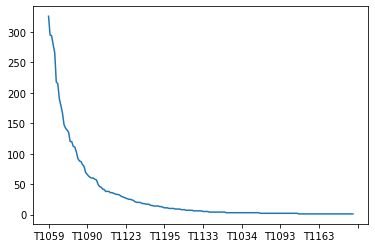

In [19]:
Y_s[rs].sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

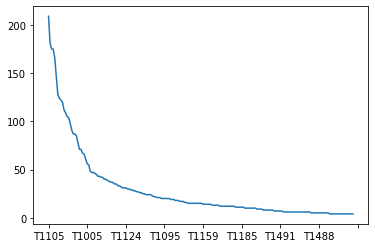

In [20]:
Y_r[rs].sum(axis=0).sort_values(ascending=False).plot()

In [21]:
Y1 = Y_s[rs]
Y1[r_s] = 0
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the techniques in Y1

<ipython-input-21-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
<ipython-input-21-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
<ipython-input-21-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y

In [22]:
X_r_train, X_test_text, Y_r_train, Y_test = train_test_split(X_r, Y_r, test_size=0.3,
                                                    random_state = 10)

In [23]:
X_train_text = pd.concat([X_r_train, X_s])

In [24]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

# Feature Selection: 

In [25]:
# ------------ Count Vectorizer --------------- 

# cv = CountVectorizer(analyzer='word', stop_words='english', lowercase=False,
                        #min_df=0.01) # if words used less than 0.001 % --> ignore  
# data = cv.fit_transform(df_tech['text']) 

# df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())

# ---------------- TF-IDF ---------------------: 


tf_idf = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df=2, max_df=0.99)

X_train = tf_idf.fit_transform(X_train_text)

X_train = pd.DataFrame(X_train.toarray(), columns=tf_idf.get_feature_names()) 

X_test = tf_idf.transform(X_test_text)

X_test = pd.DataFrame(X_test.toarray(), columns=tf_idf.get_feature_names()) 


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Measuring Cosine Similarity to Remove Duplicates: 

In [26]:
similarities = cosine_similarity(X_train, X_test)

In [27]:
# check if articles have a cosine similarity of more than 90%
duplicates = set() 
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            
            duplicates.add(i)

In [28]:
# remove similar articles
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]

# SVM:

In [29]:
# Train and test: First delete techniques less than 9 
# We fix the random state to have the same dataset in our different tests

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(X_train, Y_train)


OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', dual=False,
                                        random_state=42),
                    n_jobs=1)

In [30]:
Y_pred = pd.DataFrame(sv_classifier.predict(X_test), columns=Y_test.columns)

In [31]:
f_score_dict = {}
for col in Y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(Y_test[col], Y_pred[col],beta=0.5)
    print(classification_report(Y_test[col], Y_pred[col]))

T1066
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       0.50      0.33      0.40         3

    accuracy                           0.99       441
   macro avg       0.75      0.67      0.70       441
weighted avg       0.99      0.99      0.99       441

T1047
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       422
           1       0.64      0.37      0.47        19

    accuracy                           0.96       441
   macro avg       0.80      0.68      0.72       441
weighted avg       0.96      0.96      0.96       441

T1156
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      0.67      0.80         3

    accuracy                           1.00       441
   macro avg       1.00      0.83      0.90       441
weighted avg       1.00      1.00      1.00       441

T1165
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

T1137
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      1.00      1.00         4

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

T1089
              precision    recall  f1-score   support



/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       0.67      0.67      0.67         3

    accuracy                           1.00       441
   macro avg       0.83      0.83      0.83       441
weighted avg       1.00      1.00      1.00       441

T1219
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       0.67      0.50      0.57         4

    accuracy                           0.99       441
   macro avg       0.83      0.75      0.78       441
weighted avg       0.99      0.99      0.99       441

T1079
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       1.00      0.50      0.67         2

    accuracy                           1.00       441
   macro avg       1.00      0.75      0.83       441
weighted avg       1.00      1.00      1.00       441

T1036
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       432
           1       1.00      0.22      0.36         9

    accuracy                           0.98       441
   macro avg       0.99      0.61      0.68       441
weighted avg       0.98      0.98      0.98       441

T1019
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       437
           1       1.00      0.25      0.40         4

    accuracy                           0.99       441
   macro avg       1.00      0.62      0.70       441
weighted avg       0.99      0.99      0.99       441

T1042
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      0.50      0.67         4

    accuracy                           1.00       441
   macro avg       1.00      0.75      0.83       441
weighted avg       1.00      1.00      0.99       441

T1117
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       1.00      1.00      1.00         1

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

T1057
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       407
           1       0.57      0.47      0.52        34

    accuracy                           0.93       441
   macro avg       0.76      0.72      0.74       441
weighted avg       0.93      0.93      0.93       441

T1141
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      0.33      0.50         3

    accuracy                           1.00       441
   macro avg       1.00      0.67      0.75       441
weighted avg       1.00      1.00      0.99       441

T1041
 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       429
           1       0.33      0.33      0.33        12

    accuracy                           0.96       441
   macro avg       0.66      0.66      0.66       441
weighted avg       0.96      0.96      0.96       441

T1168
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      0.33      0.50         3

    accuracy                           1.00       441
   macro avg       1.00      0.67      0.75       441
weighted avg       1.00      1.00      0.99       441

T1100
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       0.50      0.17      0.25         6

    accuracy                           0.99       441
   macro avg       0.74      0.58      0.62       441
weighted avg       0.98      0.99      0.98       441

T1186
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       430
           1       0.60      0.27      0.37        11

    accuracy                           0.98       441
   macro avg       0.79      0.63      0.68       441
weighted avg       0.97      0.98      0.97       441

T1052
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       0.00      0.00      0.00         0

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1105
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       380
           1       0.71      0.59      0.64        61

    accuracy                           0.91       441
   macro avg       0.82      0.78      0.80       441
weighted avg       0.90      0.91      0.91       441

T1084
 

In [32]:
f_score_dict

{'T1066': 0.45454545454545453,
 'T1047': 0.5555555555555555,
 'T1156': 0.0,
 'T1113': 0.7916666666666666,
 'T1067': 0.0,
 'T1037': 0.45454545454545453,
 'T1033': 0.5434782608695652,
 'T1003': 0.41984732824427484,
 'T1129': 0.7142857142857143,
 'T1492': 0.0,
 'T1044': 0.0,
 'T1171': 0.8333333333333334,
 'T1014': 0.5769230769230769,
 'T1501': 0.8333333333333334,
 'T1123': 0.7843137254901961,
 'T1133': 0.0,
 'T1109': 0.0,
 'T1099': 0.13888888888888887,
 'T1069': 0.6818181818181818,
 'T1114': 0.8333333333333334,
 'T1163': 0.0,
 'T1025': 1.0,
 'T1116': 0.47619047619047616,
 'T1093': 0.29411764705882354,
 'T1178': 0.3846153846153846,
 'T1013': 0.0,
 'T1192': 0.1515151515151515,
 'T1489': 0.45454545454545453,
 'T1206': 0.0,
 'T1063': 0.2631578947368421,
 'T1080': 0.7142857142857143,
 'T1167': 0.9090909090909091,
 'T1165': 0.0,
 'T1137': 1.0,
 'T1089': 0.1724137931034483,
 'T1487': 0.13157894736842105,
 'T1214': 0.7142857142857143,
 'T1119': 1.0,
 'T1115': 0.8333333333333334,
 'T1103': 0.83333

In [33]:
np.mean(list(f_score_dict.values()))

0.4544202787291782